# ML-Pipeline zur Klassifikation

Wir nutzen das in scikit-learn bereitgestellte Dataset ["20newsgroups"](https://scikit-learn.org/stable/datasets/real_world.html#the-20-newsgroups-text-dataset) mit 18000 Newsgroups Beiträgen in 20 Kategorien zur Klassifikation von Textdaten. Die in diesem Notebook vorgestellte ML-Pipeline umfasst dabei:
* Exploration und Vorverarbeitung der Daten
* Feature Engineering
* Training von zwei Modellen mit Parameter-Optimierung
* Evaluierung der Modelle


In [1]:
# Import und Initialisierung des KI-Assistenten bia-bob
from bia_bob import bob
# API Key wird aus condas Umgebungsvariable gelesen
bob.initialize(endpoint='blablador', model='alias-fast')

import pandas as pd
from pprint import pprint
import matplotlib.pyplot as plt

## Datenexploration

In [2]:
from sklearn.datasets import fetch_20newsgroups

# Newsgroup Daten vollständig für Exploration laden
ng_all = fetch_20newsgroups(subset='all')

In [3]:
# Überprüfen des Datentyps und der verfügbaren Methoden und Objekte
print(type(ng_all))
print(dir(ng_all))

<class 'sklearn.utils._bunch.Bunch'>
['DESCR', 'data', 'filenames', 'target', 'target_names']


In [4]:
print(type(ng_all.data))
print(type(ng_all.target))
print(type(ng_all.target_names))

<class 'list'>
<class 'numpy.ndarray'>
<class 'list'>


In [5]:
# Welche Targets / Kategorien gibt es
pprint(list(enumerate(ng_all.target_names)))

[(0, 'alt.atheism'),
 (1, 'comp.graphics'),
 (2, 'comp.os.ms-windows.misc'),
 (3, 'comp.sys.ibm.pc.hardware'),
 (4, 'comp.sys.mac.hardware'),
 (5, 'comp.windows.x'),
 (6, 'misc.forsale'),
 (7, 'rec.autos'),
 (8, 'rec.motorcycles'),
 (9, 'rec.sport.baseball'),
 (10, 'rec.sport.hockey'),
 (11, 'sci.crypt'),
 (12, 'sci.electronics'),
 (13, 'sci.med'),
 (14, 'sci.space'),
 (15, 'soc.religion.christian'),
 (16, 'talk.politics.guns'),
 (17, 'talk.politics.mideast'),
 (18, 'talk.politics.misc'),
 (19, 'talk.religion.misc')]


In [6]:
# Ausgabe der ersten 5 Einträge in Target
pprint(ng_all.target[:5])

array([10,  3, 17,  3,  4])


In [7]:
# Ausgabe von Beiträgen aus den Daten
pprint(ng_all.data[0])

('From: Mamatha Devineni Ratnam <mr47+@andrew.cmu.edu>\n'
 'Subject: Pens fans reactions\n'
 'Organization: Post Office, Carnegie Mellon, Pittsburgh, PA\n'
 'Lines: 12\n'
 'NNTP-Posting-Host: po4.andrew.cmu.edu\n'
 '\n'
 '\n'
 '\n'
 'I am sure some bashers of Pens fans are pretty confused about the lack\n'
 'of any kind of posts about the recent Pens massacre of the Devils. '
 'Actually,\n'
 'I am  bit puzzled too and a bit relieved. However, I am going to put an end\n'
 "to non-PIttsburghers' relief with a bit of praise for the Pens. Man, they\n"
 'are killing those Devils worse than I thought. Jagr just showed you why\n'
 'he is much better than his regular season stats. He is also a lot\n'
 'fo fun to watch in the playoffs. Bowman should let JAgr have a lot of\n'
 'fun in the next couple of games since the Pens are going to beat the pulp '
 'out of Jersey anyway. I was very disappointed not to see the Islanders lose '
 'the final\n'
 'regular season game.          PENS RULE!!!\n'
 '

### Verhältnisse der Klassen

Insbesondere bei Klassifikationsverfahren ist das Verhältnis der Klassen von Bedeutung. Sind Klassen extrem unterrepräsentiert (_class imbalance_), können deren Eigenschaften von einem Modell nicht verläßlich gelernt und später erkannt werden.  
Unsere Klassen und deren jeweilige Anzahl sind in `ng_all.target` enthalten. Lassen wir uns beim Zählen doch von bob helfen.

In [151]:
%bob Wie kann ich zählen, wie oft eine Zahl in der Liste {ng_all.target} vorkommt ?

 To count how often a number appears in the list, you can use the `Counter` class from the `collections` module in Python. Here is the complete code to do that:



In [8]:
# Bereits bereinigter, funktionierender Vorschlag von bob mit `Counter()`
from collections import Counter

counts = Counter(ng_all.target)
pprint(counts)

Counter({10: 999,
         15: 997,
         8: 996,
         9: 994,
         11: 991,
         13: 990,
         7: 990,
         5: 988,
         14: 987,
         2: 985,
         12: 984,
         3: 982,
         6: 975,
         1: 973,
         4: 963,
         17: 940,
         16: 910,
         0: 799,
         18: 775,
         19: 628})


## Vorverarbeitung
Die Newsgroup-Daten enthalten einige Metadaten, z.B. Einträge zum Absender, Anzahl der Zeilen, oder andere zitierte Beiträge.  
Es ist möglich, dass ein Klassifikationsmodell beginnt, diese Metadaten zu lernen, anstatt die eigentlichen Inhalte der Beiträge.  
Daher ist es ratsam, diese Metadaten zu entfernen - scikit-learn bietet hierfür direkt Möglichkeiten.

In [9]:
ng_all_clean = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
pprint(ng_all_clean.data[0])

('\n'
 '\n'
 'I am sure some bashers of Pens fans are pretty confused about the lack\n'
 'of any kind of posts about the recent Pens massacre of the Devils. '
 'Actually,\n'
 'I am  bit puzzled too and a bit relieved. However, I am going to put an end\n'
 "to non-PIttsburghers' relief with a bit of praise for the Pens. Man, they\n"
 'are killing those Devils worse than I thought. Jagr just showed you why\n'
 'he is much better than his regular season stats. He is also a lot\n'
 'fo fun to watch in the playoffs. Bowman should let JAgr have a lot of\n'
 'fun in the next couple of games since the Pens are going to beat the pulp '
 'out of Jersey anyway. I was very disappointed not to see the Islanders lose '
 'the final\n'
 'regular season game.          PENS RULE!!!\n'
 '\n')


Nun sind noch überflüssige Zeilenumbrüche in den Daten enthalten, diese wollen wir auch noch entfernen.  
Fragen wir doch unseren KI-Assistenten bob, wie wir das machen können.

In [95]:
%%bob
Ich habe eine Liste ng_all_clean.data
Einträge dieser Liste sind vom Typ String und sehen z.B. so aus: {ng_all_clean.data[0]}
Für jeden Eintrag in ng_all_clean.data mächte ich alle einleitenden und abschließenden `\n` entfernen
Gib mir dafür Python Code, es reicht ein Einzeiler.

 Here is a simple Python code snippet to remove the leading and trailing newlines from each entry in `ng_all_clean.data`:



In [10]:
# Bereits bereinigter, funktionierender Vorschlag von bob mit `.strip()`
ng_all_clean.data = [entry.strip() for entry in ng_all_clean.data]

In [11]:
pprint(ng_all_clean.data[0])

('I am sure some bashers of Pens fans are pretty confused about the lack\n'
 'of any kind of posts about the recent Pens massacre of the Devils. '
 'Actually,\n'
 'I am  bit puzzled too and a bit relieved. However, I am going to put an end\n'
 "to non-PIttsburghers' relief with a bit of praise for the Pens. Man, they\n"
 'are killing those Devils worse than I thought. Jagr just showed you why\n'
 'he is much better than his regular season stats. He is also a lot\n'
 'fo fun to watch in the playoffs. Bowman should let JAgr have a lot of\n'
 'fun in the next couple of games since the Pens are going to beat the pulp '
 'out of Jersey anyway. I was very disappointed not to see the Islanders lose '
 'the final\n'
 'regular season game.          PENS RULE!!!')


## Train-Test-Split

Bevor wir jetzt Features aus den Textdaten erzeugen, sollten wir die Daten für Training und Test trennen. Warum?  

* Weiter unten sollen TF-IDF Vektoren aus den Textdaten erzeugt werden.
* Ein Teil davon ist die Normalisierung bzgl. der Dokumentenhäufigkeit - also wie oft ein Wort über alle Dokumente vorkommt.
* Wenn diese Normalisierung bereits alle Texte beinhaltet (z.B. auch für Test), sieht das Model schon beim Training, welche Worte auch in den späteren Testdaten häufig oder selten vorkommen - sog. "Data-Leakage".

Wir teilen unsere Daten daher schon hier und entscheiden uns für einen "80:20" Split für Training und Test.  
scikit-learn bietet hierfür mit [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) eine passende Hilfsmethode.

In [12]:
from sklearn.model_selection import train_test_split

texts = ng_all_clean.data
targets = ng_all_clean.target
target_names = ng_all_clean.target_names

# 20% der Daten für Test
# Das Argument stratify sorgt dafür, dass die Targets / Kategorien gleichmäßig in Train und Test verteilt sind
X_train, X_test, y_train, y_test = train_test_split(
    texts, targets, test_size=0.20, random_state=42, stratify=targets)

print(f"Samples in X_train: {len(X_train)} und y_train: {len(y_train)}")
print(f"Samples in X_test: {len(X_test)} und y_test: {len(y_test)}")

Samples in X_train: 15076 und y_train: 15076
Samples in X_test: 3770 und y_test: 3770


Wir wollen noch einmal die Verteilung der verschiedenen Kategorien in unseren Datensätzen prüfen.  
In allen Datensätzen sollten alle Kategorien vorhanden sein, diese sollten zudem möglichst gleichverteilt sein.

In [13]:
pprint(Counter(y_train))

Counter({10: 799,
         15: 798,
         8: 797,
         9: 795,
         11: 793,
         7: 792,
         13: 792,
         5: 790,
         14: 790,
         2: 788,
         12: 787,
         3: 786,
         6: 780,
         1: 778,
         4: 770,
         17: 752,
         16: 728,
         0: 639,
         18: 620,
         19: 502})


## Feature Engineering

Unsere Daten liegen nun als vorverarbeiteter Text den zwei Datensätzen vor. Die meisten ML-Modelle benötigen numerische Feature.  
Wir werden daher numerische Repräsentationen der Text-Beiträge erstellen, welche als Feature genutzt werden können.  

Hierfür wählen wir **TF-IDF** (term frequency–inverse document frequency):
* Wir nutzen scikit-learns [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)
* Siehe auch: [User Guide zur Feature Extraktion aus Text](https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction) mit scikit-learn

**Achtung:** Um "Data-Leakage" zu vermeiden, trainieren wir den TfidfVectorizer mittels `.fit()` nur auf den Trainingsdaten. Die Transformation mittels `.transform()` wird dann mit dem trainierten Modell auf alle Datensätze angewandt.

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()

In [15]:
X_train_vec = tfidf_vectorizer.fit_transform(X_train) # idf lernt Dokumentenhäufigkeit aus 60 % Trainingsdaten
X_test_vec = tfidf_vectorizer.transform(X_test)       # nutzt dieselbe idf-Skala

In [16]:
print(X_train_vec.shape)
print(type(X_train_vec[0]))

(15076, 123548)
<class 'scipy.sparse._csr.csr_matrix'>


## Training und Evaluierung

* Training von zwei Modellen
  * Lineares Modell: [RidgeClassifier](https://scikit-learn.org/stable/modules/linear_model.html#ridge-regression-and-classification)
  * Probabilistisches Modell: [Naive Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html)
* Automatische Parameter-Optimierung mittels [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
* Evaluierung der Modelle mittels verschiedener [Klassifikations-Metriken](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-report) und einer [Confusion-Matrix](https://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix)

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

Wir definieren eine Funktion, die das Training mit Parameter-Optimierung ausführt und uns das trainierte Modell zurückgibt.

In [18]:
def run_training(clf, param_grid):
    # Defintion der Parameter-Optimierung
    gs = GridSearchCV(
        estimator=clf,          # Modell zur Optimierung
        param_grid=param_grid,  # Parameter
        scoring='f1_macro',     # Metriken für Bewertung
        n_jobs=-1,              # Parellele Ausführung
        cv=3,                   # Cross-Validierung mit 3 Splits
        refit=True,             # Modell für beste Parameter anpassen
        verbose=1
    )
    
    # Ausführen des Training mit Parameter-Optimierung
    gs.fit(X_train_vec, y_train)

    # Ausgabe der  GridSearch / Cross-Validation Ergebnisse
    cv_results = gs.cv_results_
    print(pd.DataFrame(cv_results)[['params', 'mean_test_score', 'rank_test_score']])

    # Ausgabe der besten Parameter-Kombination mit Score
    print('Beste Parameter:', gs.best_params_)
    print('Score für beste Parameter:', gs.best_score_)

    # Bestes Modell zurück
    return gs.best_estimator_

Wir definieren uns eine Funktion, die die Evaluierung für ein trainiertes Modell auf den Testdaten durchführt.

In [25]:
def run_eval(clf):
    # Vorhersage des Modells auf Testdaten
    predictions = clf.predict(X_test_vec)
    
    # Ausgabe der Klassifikations-Metriken
    print(classification_report(y_test, predictions, target_names=target_names))

    # Plot der Confusion Matrix
    fig, ax = plt.subplots(figsize=(10, 6))
    ConfusionMatrixDisplay.from_predictions(
        y_true=y_test, 
        y_pred=predictions,
        display_labels=target_names,
        xticks_rotation=90,
        ax=ax,
    )
    ax.set_title(f'Confusion Matrix für {clf.__class__.__name__}')
    plt.show()

### RidgeClassifier

Der RidgeClassifier ist eine für Klassifikation angepasste Variante einer Ridge Regression.

In [21]:
from sklearn.linear_model import RidgeClassifier

ridge_clf = RidgeClassifier()

# Festlegen der zu optimierenden Parameter
ridge_param_grid = {
    'alpha': [0.1, 1.0, 5.0],
    'tol': [0.0001, 0.001, 0.01]
}

# Training durchführen und bestes Modell zurückgeben lassen
best_ridge_clf = run_training(clf=ridge_clf, param_grid=ridge_param_grid)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
                          params  mean_test_score  rank_test_score
0  {'alpha': 0.1, 'tol': 0.0001}         0.720058                5
1   {'alpha': 0.1, 'tol': 0.001}         0.720227                4
2    {'alpha': 0.1, 'tol': 0.01}         0.720016                6
3  {'alpha': 1.0, 'tol': 0.0001}         0.738320                1
4   {'alpha': 1.0, 'tol': 0.001}         0.738259                2
5    {'alpha': 1.0, 'tol': 0.01}         0.737760                3
6  {'alpha': 5.0, 'tol': 0.0001}         0.715964                7
7   {'alpha': 5.0, 'tol': 0.001}         0.715796                9
8    {'alpha': 5.0, 'tol': 0.01}         0.715893                8
Beste Parameter: {'alpha': 1.0, 'tol': 0.0001}
Score für beste Parameter: 0.738319903058211


                          precision    recall  f1-score   support

             alt.atheism       0.71      0.57      0.63       160
           comp.graphics       0.79      0.78      0.79       195
 comp.os.ms-windows.misc       0.73      0.72      0.72       197
comp.sys.ibm.pc.hardware       0.71      0.78      0.74       196
   comp.sys.mac.hardware       0.82      0.75      0.78       193
          comp.windows.x       0.88      0.88      0.88       198
            misc.forsale       0.80      0.76      0.78       195
               rec.autos       0.53      0.86      0.65       198
         rec.motorcycles       0.87      0.72      0.79       199
      rec.sport.baseball       0.89      0.86      0.87       199
        rec.sport.hockey       0.93      0.90      0.92       200
               sci.crypt       0.87      0.84      0.85       198
         sci.electronics       0.81      0.79      0.80       197
                 sci.med       0.82      0.83      0.83       198
         

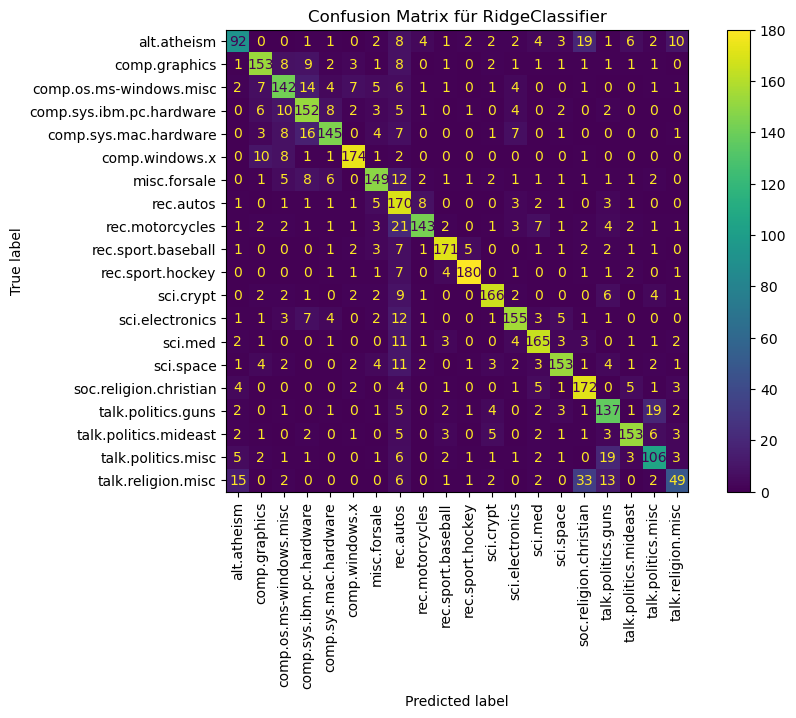

In [26]:
# Bestes Modell mit Testdaten evaluieren
run_eval(clf=best_ridge_clf)

### Naive Bayes

Wir wählen [Complement Naive Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html#complement-naive-bayes), eine Variante des Multinomial Naive Bayes, allerdings besser geeignet für Text und robuster bei Klassenungleichgewichten.

In [23]:
from sklearn.naive_bayes import ComplementNB

# Naive Bayes Modell initialisieren
nb_clf = ComplementNB()

# Festlegen der zu optimierenden Parameter
nb_param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1.0],
}

# Training durchführen und bestes Modell zurückgeben lassen
best_nb_clf = run_training(clf=nb_clf, param_grid=nb_param_grid)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
             params  mean_test_score  rank_test_score
0  {'alpha': 0.001}         0.694564                4
1   {'alpha': 0.01}         0.719720                3
2    {'alpha': 0.1}         0.739355                1
3    {'alpha': 1.0}         0.727849                2
Beste Parameter: {'alpha': 0.1}
Score für beste Parameter: 0.7393547301876325


                          precision    recall  f1-score   support

             alt.atheism       0.39      0.58      0.46       160
           comp.graphics       0.82      0.77      0.80       195
 comp.os.ms-windows.misc       0.77      0.66      0.71       197
comp.sys.ibm.pc.hardware       0.71      0.82      0.76       196
   comp.sys.mac.hardware       0.85      0.75      0.80       193
          comp.windows.x       0.83      0.90      0.86       198
            misc.forsale       0.80      0.71      0.76       195
               rec.autos       0.86      0.81      0.84       198
         rec.motorcycles       0.88      0.78      0.83       199
      rec.sport.baseball       0.91      0.87      0.89       199
        rec.sport.hockey       0.86      0.94      0.90       200
               sci.crypt       0.88      0.84      0.86       198
         sci.electronics       0.83      0.76      0.79       197
                 sci.med       0.84      0.87      0.85       198
         

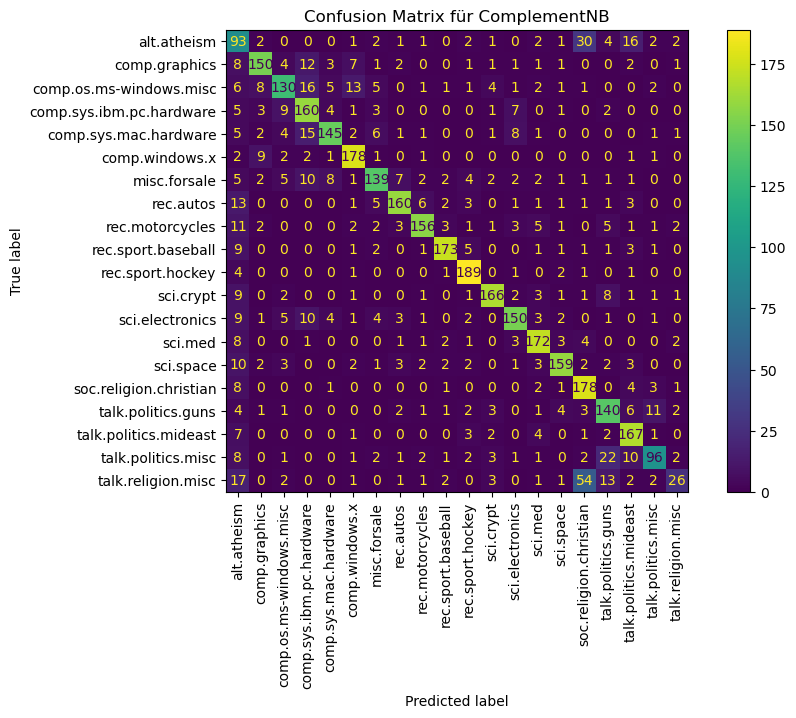

In [27]:
# Bestes Modell mit Testdaten evaluieren

run_eval(clf=best_nb_clf)